# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from torch import nn
import torch
from torch import optim
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import copy

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
rewards = env_info.rewards 
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print((states[1]))
print(rewards)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]
[0.0, 0.0]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
# code by udacity (alexis)
class OUNoise:
    """Ornstein-Uhlenbeck process."""
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [6]:
# constants 
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.99          # discount factor
TAU = 1e-3              # for soft update of target parameters
ACTOR_LR = 1e-3               # learning rate 
CRITICS_LR = 1e-3               # learning rate 
WEIGHT_DECAY = 0
UPDATE_EVERY = 2       # how often to update the network



In [7]:
# Networks
class Critics_network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 64, 64, 4 units each
        self.fc1 = nn.Linear(24, 400)
        self.fc2 = nn.Linear(400 + 2, 300)
        # Output layer, 4 units - one for each action
        self.fc3 = nn.Linear(300, 1)
    def forward(self, x, action):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = torch.cat([x, action],1)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Actor_network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 64, 64, 4 units each
        self.fc1 = nn.Linear(24, 200)
        self.fc2 = nn.Linear(200, 150)
        # Output layer, 4 units - one for each action
        self.fc3 = nn.Linear(150, 2)
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.tanh(x)
        

In [8]:
# Replay Buffer 
class ReplayBuffer:
    
    def __init__(self, buffer_size, batch_size, seed):
        self.batch_size = batch_size
        self.memory = deque(maxlen = buffer_size)
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        if done:
            done_value = 1
        else:
            done_value = 0
        self.memory.append([state, action, reward, next_state, done_value])
    
    def sample(self):
        samples = (random.sample(self.memory, self.batch_size))
        
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        
        for sample in samples:
            state, action, reward, next_state, done = sample
            
            states.append(torch.tensor(state).float())
            actions.append(torch.tensor(action).float())
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        
            
        states = torch.cat(states).float().view(len(samples), -1)
        actions = torch.cat(actions).float().view(len(samples), -1)
        rewards = torch.tensor(rewards).float()
        next_states = torch.tensor(next_states).float()
        dones = torch.tensor(dones).float()
        
        return [states,actions,rewards,next_states,dones]
        
    
    def __len__(self):
        return len(self.memory)

In [9]:
# Agent
class Agent():
    def __init__(self, seed):
        self.critics_local = Critics_network()
        self.critics_target = Critics_network()
        self.actor_local = Actor_network()
        self.actor_target = Actor_network()
        self.seed = random.seed(seed)
        
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=ACTOR_LR)
        self.critics_optimizer = optim.Adam(self.critics_local.parameters(), lr=CRITICS_LR, weight_decay = WEIGHT_DECAY)
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        
        self.noise = OUNoise(2, self.seed)
        
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if (len(self.memory)) > BATCH_SIZE:
                samples = self.memory.sample()
                self.learn(samples, GAMMA)
    
    def act(self, state, eps = 0):
        state = torch.from_numpy(state).float()
        with torch.no_grad():
            action_values = self.actor_local(state)
        
        action_values += (torch.tensor(self.noise.sample()).float())
        return np.clip(action_values, -1, 1)    
            
    def learn(self, samples, gamma):
        "*** YOUR CODE HERE ***"

        states, actions, rewards, next_states, dones = samples
        #dimensional fit of rewards and dones
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)

        # Compute Targets
        q_values_next_states = self.critics_target.forward(next_states, self.actor_target(next_states))
        targets = rewards + (gamma * (q_values_next_states) *  (1 - dones))
        predictions = self.critics_local.forward(states, actions)
        
        # loss & step of critic
        loss = F.mse_loss(predictions, targets)
        self.critics_optimizer.zero_grad()
        loss.backward()
        self.critics_optimizer.step()
        
        # 
        actor_losses = self.critics_local.forward(states, self.actor_local(states))
        actor_loss = - actor_losses.mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # ------------------- update target network ------------------- #
        self.soft_update(self.critics_local, self.critics_target, TAU)  
        self.soft_update(self.actor_local, self.actor_target, TAU)  

        
 
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Episode 10	Average Score: 0.01
Episode 20	Average Score: 0.02
Episode 30	Average Score: 0.01
Episode 40	Average Score: 0.01
Episode 50	Average Score: 0.01
Episode 60	Average Score: 0.01
Episode 70	Average Score: 0.00
Episode 80	Average Score: 0.00
Episode 90	Average Score: 0.00
Episode 100	Average Score: 0.00
Episode 110	Average Score: 0.00
Episode 120	Average Score: 0.00
Episode 130	Average Score: 0.00
Episode 140	Average Score: 0.00
Episode 150	Average Score: 0.00
Episode 160	Average Score: 0.00
Episode 170	Average Score: 0.00
Episode 180	Average Score: 0.00
Episode 190	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 210	Average Score: 0.00
Episode 220	Average Score: 0.00
Episode 230	Average Score: 0.00
Episode 240	Average Score: 0.00
Episode 250	Average Score: 0.00
Episode 260	Average Score: 0.00
Episode 270	Average Score: 0.00
Episode 280	Average Score: 0.00
Episode 290	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 310	Average Score: 0.00
Episode 320	Avera

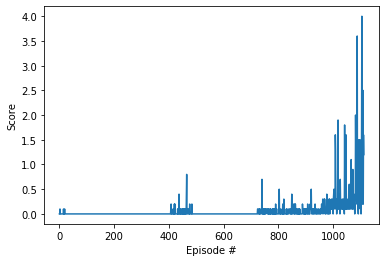

In [10]:
#DDPG algorithm
def ddpg(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.0001, eps_decay=0.995):
    env_info = env.reset(train_mode=True)[brain_name]
    agent = Agent(0)
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = 0
        
        while True:
            actions = []
            for state in states:
                action = agent.act(state, eps).numpy()
                actions.append(action)
            
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                 # get the reward
            dones = env_info.local_done
            for (state,action, reward,next_state, done) in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            states = next_states
            score += np.max(rewards)
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critics_local.state_dict(),'critics_checkpoint.pth' )
            break  
    return agent, scores

agent, scores = ddpg()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
env_info = env.reset(train_mode=True)[brain_name]
states = env_info.vector_observations
score = 0
while True:
    actions = []
    for state in states:
        action = agent.act(state, 0).numpy()
        actions.append(action)

    env_info = env.step(actions)[brain_name]        # send the action to the environment
    next_states = env_info.vector_observations   # get the next state
    rewards = env_info.rewards                 # get the reward
    dones = env_info.local_done
    for (state,action, reward,next_state, done) in zip(states, actions, rewards, next_states, dones):
        agent.step(state, action, reward, next_state, done)
    states = next_states
    score += np.max(rewards)
    if done:
        break
print("Finished with score ", score)    

Finished with score  5.200000077486038


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [14]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.09000000171363354
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [15]:
env.close()